In [1]:
!pip3 install --user ipykernel
!python3 -m ipykernel install --user --name=aue8930
!jupyter kernelspec list
#!jupyter kernelspec uninstall aue8930
!conda install --yes matplotlib

Installed kernelspec aue8930 in /home/csamak/.local/share/jupyter/kernels/aue8930
Available kernels:
  aue8930    /home/csamak/.local/share/jupyter/kernels/aue8930
  python3    /home/csamak/.local/share/jupyter/kernels/python3
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
import models
import os
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torchvision
import common
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#DIRECTORY SETTINGS
os.chdir("..")#Go up two directories
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'improve.pt')


#HYPERPARAMETERS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS=100
BATCH_SIZE = 256
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=True
LEARNING_RATE=0.001

In [4]:
train_transforms = transforms.Compose([# Data Transforms
                           transforms.Resize(256),#Resize
                           transforms.RandomHorizontalFlip(30),#Flip
                           transforms.RandomRotation(10),#Roatate
                           transforms.RandomCrop(256),#Crop
                           transforms.ToTensor(),#Convert to Tensor
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [5]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=train_transforms)#Use CIFAR10 to train
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=test_transforms)


print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [6]:
model = torchvision.models.resnet18(pretrained=True)#TorchVision

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

model = nn.DataParallel(model)#Use data parallel architecture for using 2 GPU cores simultaneously

#Hyperparameters
if(ADAM_OPTIMISER):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch:0.65**epoch)

In [7]:
#Train
train_epoch_hist = []#List to store training epoch history
train_acc_hist = []#List to store training accuracy history

best_valid_loss = float('inf')
for epoch in range(EPOCHS):#Range of Epochs
    print(epoch)
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)#Train Loss Calculation
    scheduler.step()#Update learning rate
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)#Validation Loss Calculation
    
    train_epoch_hist.append(epoch+1)#Append current epoch to history
    train_acc_hist.append(train_acc)#Append current accuracy to history   

    if valid_loss < best_valid_loss:#Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss#Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)#Save the model

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

0
| Epoch: 01 | Train Loss: 1.322 | Train Acc: 59.14% | Val. Loss: 0.916 | Val. Acc: 70.91% |
1
| Epoch: 02 | Train Loss: 0.884 | Train Acc: 71.70% | Val. Loss: 0.815 | Val. Acc: 73.07% |
2
| Epoch: 03 | Train Loss: 0.814 | Train Acc: 73.23% | Val. Loss: 0.779 | Val. Acc: 74.10% |
3
| Epoch: 04 | Train Loss: 0.786 | Train Acc: 73.96% | Val. Loss: 0.757 | Val. Acc: 75.19% |
4
| Epoch: 05 | Train Loss: 0.771 | Train Acc: 74.60% | Val. Loss: 0.748 | Val. Acc: 75.30% |
5
| Epoch: 06 | Train Loss: 0.765 | Train Acc: 74.61% | Val. Loss: 0.739 | Val. Acc: 74.98% |
6
| Epoch: 07 | Train Loss: 0.757 | Train Acc: 74.86% | Val. Loss: 0.732 | Val. Acc: 75.51% |
7
| Epoch: 08 | Train Loss: 0.754 | Train Acc: 74.87% | Val. Loss: 0.722 | Val. Acc: 75.35% |
8
| Epoch: 09 | Train Loss: 0.752 | Train Acc: 75.05% | Val. Loss: 0.737 | Val. Acc: 75.14% |
9
| Epoch: 10 | Train Loss: 0.749 | Train Acc: 75.00% | Val. Loss: 0.720 | Val. Acc: 76.32% |
10
| Epoch: 11 | Train Loss: 0.750 | Train Acc: 74.98% | Val

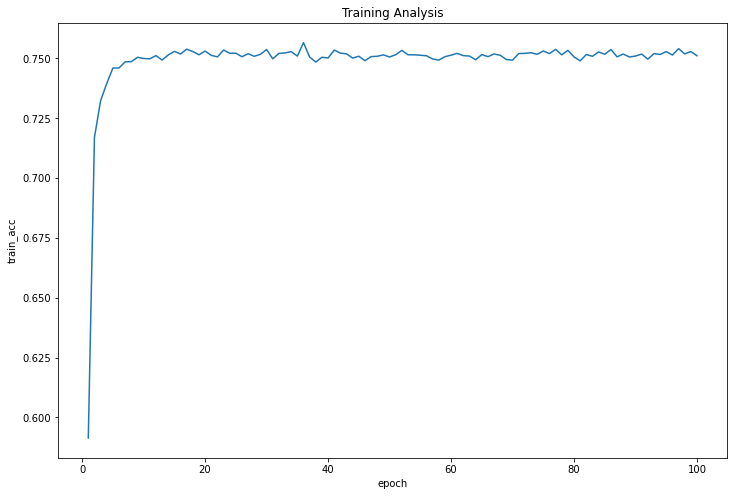

In [8]:
plt.figure(figsize=(12, 8))#Set figure size
plt.plot(train_epoch_hist, train_acc_hist)#Plot training accuracy against epochs
plt.title("Training Analysis")#Add title
plt.ylabel('train_acc')#Y-axis label
plt.xlabel('epoch')#X-axis label
plt.show()#Show plot

In [9]:
#3. OUTPUT

model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #Load best weights from file
test_loss, test_acc = common.evaluate(model, device, valid_iterator, criterion) #Test Loss is dependent on
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}%')

| Test Loss: 0.721 | Test Acc: 75.47%


Files already downloaded and verified


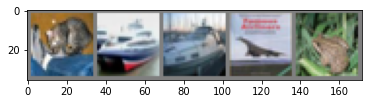

Ground Truth Labels :  Cat   Ship  Ship  Plane Frog 
Model Predictions   :  Cat   Ship  Frog  Ship  Frog 


In [10]:
#Perform a model inference for a certain image

import numpy as np

num_images = 5#Number of test images to use

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#Define transform
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)#Test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=num_images, shuffle=False, num_workers=2)#Test data loader
classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

#Get model predictions on random testing images
dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

def imshow(img):
    img = img / 2 + 0.5#Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))#Show images
print('Ground Truth Labels : ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))#Print ground truth labels
print('Model Predictions   : ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_images)))#Print model predictions